In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from keras.utils import to_categorical
import random
import pandas as pd
import dlib
from scipy.spatial import distance 
import math
from imutils import face_utils
from sklearn.metrics import accuracy_score
import joblib

In [2]:
# Put the directory of the train dataset in the quotation mark
train_dataset_dir = r""
# Put the directory of the test dataset in the quotation mark
test_dataset_dir = r""

In [3]:
# Using a pre-trained model to extract face landmarks
p = "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)

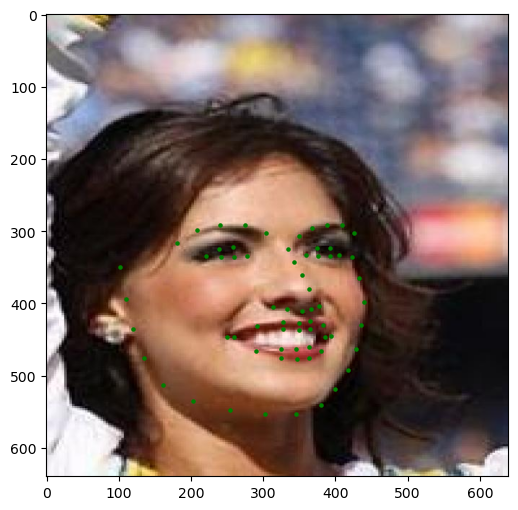

In [6]:
# Plotting the 68 landmarks found on the image
# Put in the quotation mark, the directory of a random image
img_path=r''
image= cv2.imread(img_path)
image_rgb=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
rects=detector(image, 0)
plt.figure(figsize=(8,6))
plt.imshow(image_rgb)
for (i, rect) in enumerate(rects):
    shape=predictor(gray, rect)
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)
    for(x, y) in shape:
        plt.scatter(x,y, color='green', s=5)

In [7]:
# Defining function to get eye_aspect ratio: ear
def eye_aspect_ratio(eye):
	A = distance.euclidean(eye[1], eye[5])
	B = distance.euclidean(eye[2], eye[4])
	C = distance.euclidean(eye[0], eye[3])
	ear = (A + B) / (2.0 * C)
	return ear

In [8]:
#Defining function to get circularity of the eye
def circularity(eye):
    A = distance.euclidean(eye[1], eye[4])
    radius  = A/2.0
    Area = math.pi * (radius ** 2)
    p = 0
    p += distance.euclidean(eye[0], eye[1])
    p += distance.euclidean(eye[1], eye[2])
    p += distance.euclidean(eye[2], eye[3])
    p += distance.euclidean(eye[3], eye[4])
    p += distance.euclidean(eye[4], eye[5])
    p += distance.euclidean(eye[5], eye[0])
    return 4 * math.pi * Area /(p**2)

In [11]:
def process_directory(directory):
    classes=[]
    data=[]
    features=[]
    labels=[]
    image_size=(224,224)
    # Load Dataset and Normalize
    for path, subdirs, files in os.walk(directory):
        num_files = len(files)
        num_to_select = num_files
        selected_files = random.sample(files, num_to_select)
        
        for name in tqdm(selected_files):
            img_path = os.path.join(path, name)
            img= cv2.imread(img_path)
            img= cv2.resize(img, (224,224))
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            rects=detector(img, 0)
            
            for (i, rect) in enumerate(rects):
                shape=predictor(gray, rect)
                shape = predictor(gray, rect)
                shape = face_utils.shape_to_np(shape)
                data.append(shape)
                path_parts = path.split('/')
                label = path_parts[-1]
                if label not in classes:
                    classes.append(label)
                index = classes.index(label)
                labels.append(index)
    
    features = pd.DataFrame(columns=["EAR","Circularity"])
    for d in data:
        eye=d[36:68]
        ear=eye_aspect_ratio(eye)
        cir=circularity(eye)
        new_row = ({"EAR":ear,"Circularity": cir})
        features.loc[len(features)] = new_row
        
    return features, labels

In [17]:
features_train, labels_train=process_directory(train_dataset_dir)

0it [00:00, ?it/s]
100%|██████████| 1380/1380 [00:23<00:00, 59.98it/s]


In [18]:
X_train = np.asarray(features_train)
y_train = np.asarray(labels_train)

In [19]:
y_train=to_categorical(y_train)

In [20]:
# Repeat the same process for the test dataset

In [21]:
features_test, labels_test=process_directory(test_dataset_dir)

0it [00:00, ?it/s]
100%|██████████| 123/123 [00:02<00:00, 52.27it/s]


In [22]:
X_test = np.asarray(features_test)
y_test = np.asarray(labels_test)

In [23]:
y_test=to_categorical(y_test)

In [24]:
best_accuracy=0
best_k=0
for k in range(1,100):
    knn_classifier=KNeighborsClassifier(n_neighbors=k)
    
    knn_classifier.fit(X_train, y_train)
    y_pred=knn_classifier.predict(X_test)
    accuracy=accuracy_score(y_test, y_pred)
    
    if accuracy > best_accuracy:
        best_accuracy=accuracy
        best_k=k

In [25]:
print(best_accuracy)
print(best_k)

0.8588957055214724
43


In [26]:
model=KNeighborsClassifier(n_neighbors=best_k)
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=43)

In [27]:
joblib.dump(model, 'knn_model.pkl')

['knn_model.pkl']